In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.integrate as si
import scipy.optimize as so
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
from jax.config import config
config.update("jax_enable_x64", True)

<h1>TDSE Forward Problem</h1>

In [2]:
# size of spatial domain
L = 10.0
# number of real space grid points (for plotting)
numx = 1025
# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
# n = -numF to n = numF
numfour = 32

# matrix for converting Fourier representation to real space
fournvec = np.arange(-numfour, numfour + 1) # fournvec=-nfb,...,0,...,nfb
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)

---
**Potential Function**

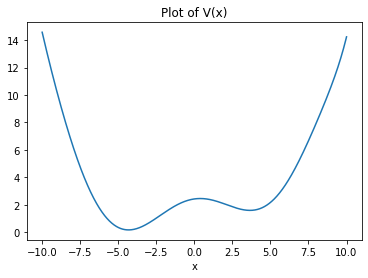

In [3]:
# define potential for generating training data

def v(z):
    # harmonic oscillator potential (should be exact for Chebyshev)
    # return 0.5 * z**2
    # symmetric double well potential
    # return 2.5e-3 * (z**2 - 25)**2
    # asymmetric double well potential
    c0 = 4.35; c1 = 9.40e-1; c2 = -3.56e-1; c3 = -4.66e-2
    c4 = 1.46e-2; c5 = 6.76e-4; c6 = -1.26e-4; c7 = -5.43e-6
    c8 = 4.12e-7; c9 = 1.65e-8
    x = z + 0.8
    return 0.5 * (c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 \
           + c6*x**6 + c7*x**7 + c8*x**8 + c9*x**9)
    # non-polynomial potentials
    # return np.sin(0.4 * z - 1)
    # return np.sin((0.5 * z)**2)
    # soft coulomb potential
    # return -1 / np.sqrt(z**2 + 0.25)


# compute true potential on real space grid for plotting
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

---
**Initial Wave Functions**

Vector L2 Error psi0_0: 4.072507283504947e-06
Vector L-infinity Error psi0_0: 1.8301527573169486e-06
Vector L2 Error psi0_1: 4.072507283501257e-06
Vector L-infinity Error psi0_1: 1.8301527573114097e-06
Vector L2 Error psi0_2: 7.817141183566903e-12
Vector L-infinity Error psi0_2: 4.1810999107383395e-13


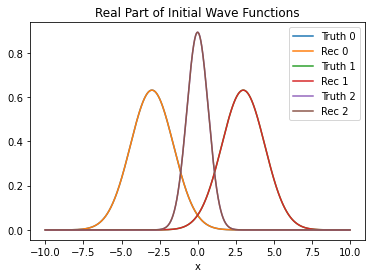

In [4]:
# define initial states and transform to Fourier basis

def psi0_0(x):
    return np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25

def psi0_1(x):
    return np.exp(-(x - 3)**2 / 4) * (2.0 / np.pi)**0.25

def psi0_2(x):
    return np.exp(-(x - 6)**2) * (2.0 / np.pi)**0.25

def psi0_3(x):
    return np.exp(-(x + 6)**2) * (2.0 / np.pi)**0.25

def psi0_4(x):
    return np.exp(-x**2) * (2.0 / np.pi)**0.25

def mka0(psi0fn):
    # compute psi0 normalization term
    psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -L, L)[0])

    # normalized psi function (for integration)
    norm_psi0fn_fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psi0fn
    norm_psi0fn = []
    for thisfourn in range (numfour + 1):
        def intgrnd(x):
            return norm_psi0fn_fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        norm_psi0fn.append(si.quad(rintgrnd, -L, L)[0] \
                           + 1j * si.quad(iintgrnd, -L, L)[0])

    a0 = np.concatenate([np.conjugate(np.flipud(norm_psi0fn[1:])), norm_psi0fn])

    normpsi0x = norm_psi0fn_fn(xvec)

    return a0, normpsi0x

psi0fnvec = [psi0_0, psi0_1, psi0_4]

a0vec = []
normpsi0xvec = []
normpsi0recxvec = []
for thispsi0fn in psi0fnvec:
    tempa0, tempnormpsi0x = mka0(thispsi0fn)
    a0vec.append(tempa0)
    normpsi0xvec.append(tempnormpsi0x)
    normpsi0recxvec.append(tempa0 @ fourtox)


# check if Fourier representation is close to truth

# plot the real part of the normalized psi0
for i in range(len(normpsi0xvec)):
    print(f'Vector L2 Error psi0_{i}:', nl.norm(normpsi0xvec[i] - normpsi0recxvec[i]))
    print(f'Vector L-infinity Error psi0_{i}:', np.max(np.abs(normpsi0xvec[i] - normpsi0recxvec[i])))
    plt.plot(xvec, normpsi0xvec[i].real, label=f"Truth {i}")
    plt.plot(xvec, normpsi0recxvec[i].real, label=f"Rec {i}")

plt.title('Real Part of Initial Wave Functions')
plt.xlabel('x')
plt.legend()
plt.show()

---
<h3>Foward Propagation</h3>

In [5]:
# transform potential to Fourier representation

# in tdse-adj-cheb-fft-vs-quad-kbc.ipynb we show that the
# quadrature method produces much more accurate results than FFT
fourvtoep = []
for thisfourn in range(2 * numfour + 1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    fourvtoep.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
vmattrue = sl.toeplitz(r=fourvtoep, c=np.conj(fourvtoep))

print('Shape vmattrue:', vmattrue.shape)

Shape vmattrue: (65, 65)


---
**Eigendecomposition of a Fourier Represented Potential**

In [6]:
# kinetic operator in the Fourier representation
# (this is constant for a given system)
kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))

# Hamiltonian operator in the Fourier representation
hmattrue = kmat + vmattrue

# check if the Hamiltonian matrix is Hermitian
print('hmattrue Hermitian check (should be close to zero):', nl.norm(hmattrue - hmattrue.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
spctrue, stttrue = nl.eigh(hmattrue)

# check if the decomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('hmattrue diagonalized check (should be close to zero):', nl.norm(hmattrue @ stttrue - stttrue @ np.diag(spctrue)), sep='\n')

# check if the eigenstates are unitary
print('stttrue unitary check (should be close to zero):', nl.norm(stttrue @ stttrue.T.conj() - np.eye(2 * numfour + 1)), sep='\n')

hmattrue Hermitian check (should be close to zero):
0.0
hmattrue diagonalized check (should be close to zero):
2.6022021582759417e-13
stttrue unitary check (should be close to zero):
1.1796799856311874e-14


---

[0.58347051 1.36721985 1.93287887 2.0619398  2.47662914 2.68184405]


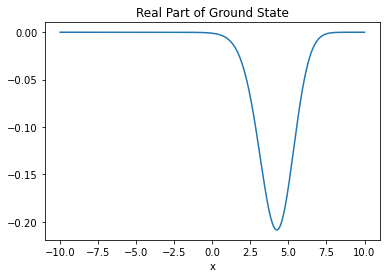

Quick normalization check (should be close to 1):
1.0000000000000004
Accurate normalization check (should be close to 1):
1.0000000000000002


In [7]:
# find indices that sort eigenvalues
ordering = np.argsort(spctrue)

# print the first few eigenvalues
print(spctrue[ordering[:6]])

# pick out and plot real part of the ground state
groundstate = ordering[0]
wavefn = stttrue[:, groundstate] @ fourtox
plt.plot(xvec, np.real(wavefn))
plt.title('Real Part of Ground State')
plt.xlabel('x')
plt.show()

# quick and dirty check of normalization
print('Quick normalization check (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Accurate normalization check (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

---
**Propagate**

In [8]:
# set time-step size
dt = 1e-2

# set number of time steps
# trajectory length is numts + 1 (initial state + numts steps)
numts = 100  # 200


# compute propagator matrix
propatrue = stttrue @ np.diag(np.exp(-1j * spctrue * dt)) @ stttrue.conj().T

amattruevec = []
# propagate system starting from initial "a" state
for thisa0 in a0vec:
    tempahatmat = [thisa0.copy()]
    for i in range(numts):
        tempahatmat.append(propatrue @ tempahatmat[-1])
    amattruevec.append(tempahatmat)

amattruevec = np.array(amattruevec)

print('Shape amattruevec:', amattruevec.shape)

print('Done propagating')

Shape amattruevec: (3, 101, 65)
Done propagating


In [9]:
# check system's state is normalized to 1 for each
# time step

psimatvec = amattruevec @ fourtox
print('Shape psimatvec:', psimatvec.shape)
print('psimatvec.shape[2]:', psimatvec.shape[2])

normpsimatvec = si.trapezoid(np.abs(psimatvec)**2, xvec, axis=2)
print('Shape normpsimatvec:', normpsimatvec.shape)

Shape psimatvec: (3, 101, 1025)
psimatvec.shape[2]: 1025
Shape normpsimatvec: (3, 101)


Average Norm of Trajectory 0 (should be close to 1):
0.999999999999584
Average Norm of Trajectory 1 (should be close to 1):
0.9999999999996184
Average Norm of Trajectory 2 (should be close to 1):
0.9999999999999494


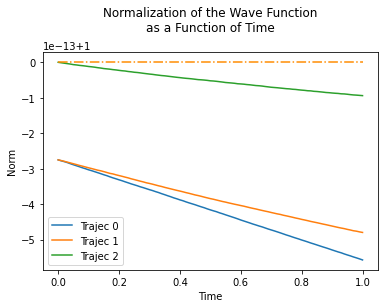

In [10]:
# plot normalization (should be almost flat line at 1)

for i in range(normpsimatvec.shape[0]):
    print(f'Average Norm of Trajectory {i} (should be close to 1):', normpsimatvec[i].sum() / (numts + 1), sep='\n')
    plt.plot(np.arange(numts + 1) * dt, normpsimatvec[i], label=f'Trajec {i}')

plt.hlines(1, 0, numts * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.legend()
plt.show()


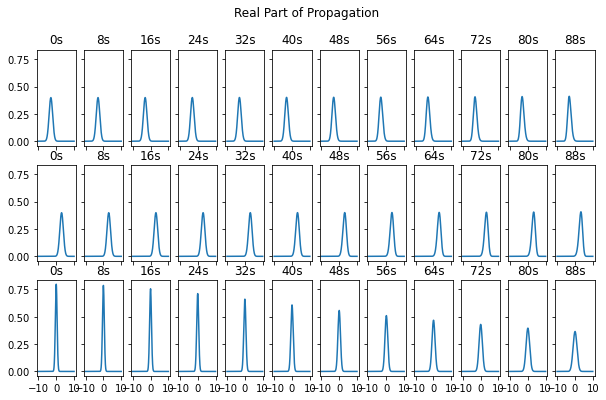

In [11]:
# look at propagation results for anything that may cause
# issues as learning data

numsnapshots = 12

fig, axs = plt.subplots(nrows=len(a0vec), ncols=numsnapshots, sharex='all', sharey='all', figsize=(10, 6))

plottstep = numts // numsnapshots

for i in range(len(a0vec)):
    for j in range(numsnapshots):
        axs[i, j].plot(xvec, np.abs(psimatvec[i, plottstep * j]) ** 2)
        axs[i, j].set_title(f'{plottstep * j * dt}s')


fig.suptitle('Real Part of Propagation')

plt.show()

---
<h3>Chebyshev Representation</h3>

In [12]:
# set the number of Chebyshev coefficients
# from experience, odd values work best
numcheb = 11  # 31

def theta(k):
    return (k - 0.5) * np.pi / (numcheb + 1)

def g(k):
    return v(L * np.cos(theta(k)))

kvec = np.arange(1, numcheb + 2)
chebnvec = np.arange(0, numcheb + 1)

chebweights = np.ones(numcheb + 1)
chebweights[0] = 0.5

chebtox = ss.eval_chebyt(np.expand_dims(chebnvec, 0), np.expand_dims(xvec / L, 1))

[ 6.30089288e+00  5.19674852e-01  6.64573526e+00 -6.96001014e-01
  1.90705582e+00 -1.25458680e-01 -6.58677000e-01  1.01520313e-01
  2.07343750e-01  3.22265625e-02 -1.28045722e-14  3.88578059e-15]


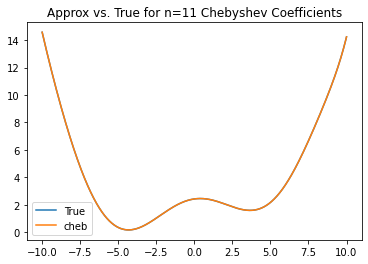

Reconstruction L2 Error (should be close to zero):
3.4519210698760405e-13
Reconstruction L-infinity Error (should be close to zero):
5.1514348342607263e-14


In [13]:
# compute Chebyshev coefficients for true potential
cfftrue = 2 / (numcheb + 1) * np.sum(g(kvec) * np.cos(chebnvec[..., np.newaxis] * theta(kvec)), axis=1)
cfftrue = chebweights * cfftrue
print(cfftrue)

# plot reconstruction vs truth
plt.plot(xvec, vxvec, label='True')
plt.plot(xvec, chebtox @ cfftrue, label='cheb')
plt.title(f'Approx vs. True for n={numcheb} Chebyshev Coefficients')
plt.legend()
plt.show()

# vec L2 error
print('Reconstruction L2 Error (should be close to zero):', nl.norm(v(xvec) - chebtox @ cfftrue), sep='\n')
# L-infinity error
print('Reconstruction L-infinity Error (should be close to zero):', np.max(np.abs(v(xvec) - chebtox @ cfftrue)), sep='\n')

---
**Propagation using Chebyshev Representation**

Shape chebtofour: (65, 65, 12)
L2 Error of vmat (should be close to 0):
3.709717990107802e-13
L-infinity Error of vmat (should be close to 0):
4.194175296290787e-14


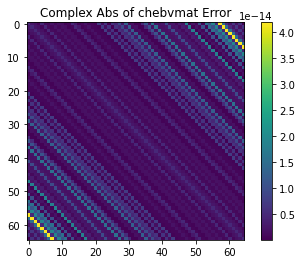

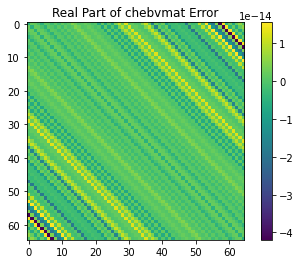

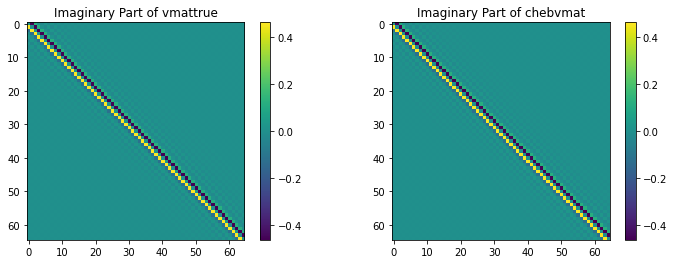

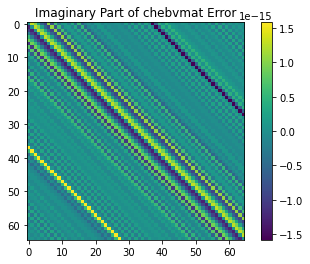

In [14]:
# matrix to transform cheb to four
chebtofour = []
for thischebn in range(numcheb + 1):
    temptoeprow = []
    for thisfourn in range(2 * numfour + 1):
        def intgrnd(x):
            return ss.eval_chebyt(thischebn, x / L) \
                   * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        temptoeprow.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
    chebtofour.append(sl.toeplitz(r=temptoeprow, c=np.conj(temptoeprow)))

chebtofour = np.transpose(np.array(chebtofour), [1, 2, 0])
print('Shape chebtofour:', chebtofour.shape)

chebvmat = chebtofour @ cfftrue

# check if potential in Fourier representation
# constructed from Chebyshev coefficients close to
# true Fourier coefficients
print('L2 Error of vmat (should be close to 0):', nl.norm(vmattrue - chebvmat), sep='\n')
print('L-infinity Error of vmat (should be close to 0):', np.max(np.abs(vmattrue - chebvmat)), sep='\n')

plt.imshow(np.abs(vmattrue - chebvmat))
plt.colorbar()
plt.title('Complex Abs of chebvmat Error')
plt.show()

plt.imshow(np.real(vmattrue - chebvmat))
plt.colorbar()
plt.title('Real Part of chebvmat Error')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

im0 = axs[0].imshow(np.imag(vmattrue))
fig.colorbar(im0, ax=axs[0])
axs[0].set_title('Imaginary Part of vmattrue')

im1 = axs[1].imshow(np.imag(chebvmat))
fig.colorbar(im1, ax=axs[1])
axs[1].set_title('Imaginary Part of chebvmat')

# im2 = axs[2].imshow(np.imag(vmattrue - chebvmat))
# fig.colorbar(im2, ax=axs[2])
# axs[2].set_title('Imaginary Part of chebvmat Error')

plt.show()


plt.imshow(np.imag(vmattrue - chebvmat))
plt.colorbar()
plt.title('Imaginary Part of chebvmat Error')

plt.show()

---
**Eigendecomposition of a Chebyshev Represented Potential**

In [15]:
# to test our Chebyshev representation let's compare
# the eigendecomposition of the Hamiltonian matrix
# constructed from the Chebyshev representation of
# the potential to the eigendecomposition of the
# Fourier representation

# Hamiltonian matrix
chebhmat = kmat + chebvmat

# check if the Hamiltonian matrix is Hermitian
print('Check if chebhmat is Hermitian (should be close to 0):', nl.norm(chebhmat - chebhmat.T.conj()), sep='\n')

# eigendecomposition chebhmat
chebspc, chebstt = nl.eigh(chebhmat)

# check if the decomposition diagonalizes chebhmat
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if chebhmat is diagonalized (should be close to 0):', nl.norm(chebhmat @ chebstt - chebstt @ np.diag(chebspc)), sep='\n')

# check if the eigenstates are unitary
print('Check if chebstt is Unitary (should be close to 0):', nl.norm(chebstt @ chebstt.T.conj() - np.eye(2 * numfour + 1)), sep='\n')
print('')

# check if chebhmat equal to hmattrue
print('L2 error of chebhmat and hmattrue (should be close to 0):', nl.norm(chebhmat - hmattrue), sep='\n')
print('L-infinite error of chebhmat and hmattrue (should be close to 0):', np.max(np.abs(chebhmat - hmattrue)), sep='\n')

# check if chebspc equal to spctrue
print('L2 error of chebspc and spctrue (should be close to 0):', nl.norm(chebspc - spctrue), sep='\n')
print('L-infinite error of chebspc and spctrue (should be close to 0):', np.max(np.abs(chebspc - spctrue)), sep='\n')

# check if chebstt equal to
print('L2 error of chebstt and stttrue (should be close to 0):', nl.norm(chebstt - stttrue), sep='\n')
print('L-infinite error of chebstt and stttrue (should be close to 0):', np.max(np.abs(chebstt - stttrue)), sep='\n')

Check if chebhmat is Hermitian (should be close to 0):
6.335602907875922e-16
Check if chebhmat is diagonalized (should be close to 0):
2.511221545186731e-13
Check if chebstt is Unitary (should be close to 0):
1.275024549701924e-14

L2 error of chebhmat and hmattrue (should be close to 0):
3.7143322214011356e-13
L-infinite error of chebhmat and hmattrue (should be close to 0):
4.194175296290787e-14
L2 error of chebspc and spctrue (should be close to 0):
9.960532168552468e-14
L-infinite error of chebspc and spctrue (should be close to 0):
4.263256414560601e-14
L2 error of chebstt and stttrue (should be close to 0):
2.856670482474043e-06
L-infinite error of chebstt and stttrue (should be close to 0):
9.629061382522082e-07


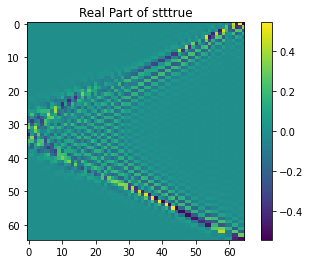

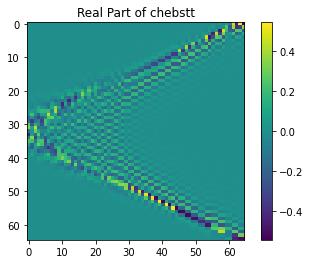

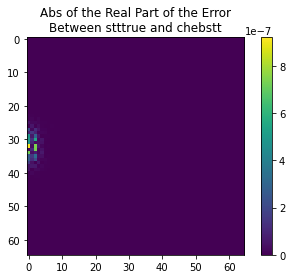

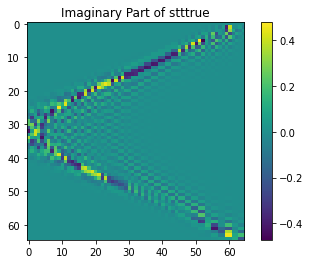

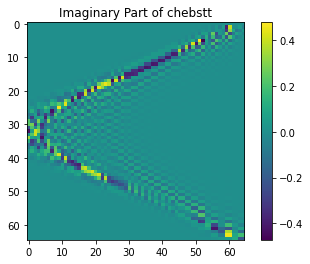

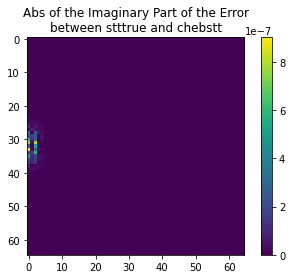

In [16]:
# plot real part of the states
plt.imshow(np.real(stttrue))
plt.title('Real Part of stttrue')
plt.colorbar()
plt.show()

plt.imshow(np.real(chebstt))
plt.title('Real Part of chebstt')
plt.colorbar()
plt.show()

plt.imshow(np.abs(np.real(stttrue - chebstt)))
plt.title('Abs of the Real Part of the Error\nBetween stttrue and chebstt')
plt.colorbar()
plt.show()

# plot imaginary part of the states
plt.imshow(np.imag(stttrue))
plt.title('Imaginary Part of stttrue')
plt.colorbar()
plt.show()

plt.imshow(np.imag(chebstt))
plt.title('Imaginary Part of chebstt')
plt.colorbar()
plt.show()

plt.imshow(np.abs(np.imag(stttrue - chebstt)))
plt.title('Abs of the Imaginary Part of the Error\nbetween stttrue and chebstt')
plt.colorbar()
plt.show()

---
**Forward Propagation of Cheybshev Representation**

In [17]:
# this is used to check if the propagation using the
# cheb representation matchs the propagation using the
# four representation

# propagator matrix
chebpropa = chebstt @ np.diag(np.exp(-1j * chebspc * dt)) @ np.transpose(np.conj(chebstt))

chebamatvec = []
# propagate the system starting from the initial "a" state
for thisa0 in a0vec:
    tempchebamat = [thisa0.copy()]
    for i in range(numts):
        tempchebamat.append(chebpropa @ tempchebamat[i])
    chebamatvec.append(tempchebamat)

print('Done propagating.')
print('')

for i in range(len(amattruevec)):
    print(f'L2 error of chebamatvec[{i}] and amattruevec[{i}]:', nl.norm(chebamatvec[i] - amattruevec[i]), sep='\n')
    print(f'L-infinite error of chebamatvec[{i}] and amattruevec[{i}]:', np.max(np.abs(chebamatvec[i] - amattruevec[i])), sep='\n')

Done propagating.

L2 error of chebamatvec[0] and amattruevec[0]:
7.072873579995996e-13
L-infinite error of chebamatvec[0] and amattruevec[0]:
5.0224095627915106e-14
L2 error of chebamatvec[1] and amattruevec[1]:
5.760600118867966e-13
L-infinite error of chebamatvec[1] and amattruevec[1]:
3.9614363466617433e-14
L2 error of chebamatvec[2] and amattruevec[2]:
6.387170596147407e-13
L-infinite error of chebamatvec[2] and amattruevec[2]:
4.376264832710602e-14


L2 Error of chebpsimatvec for Trajectory 0: 5.0612101460077635e-12
L-infinite Error of chebpsimatvec for Trajectory 0: 5.736591367313987e-14

L2 Error of chebpsimatvec for Trajectory 1: 4.1220659924045495e-12
L-infinite Error of chebpsimatvec for Trajectory 1: 4.980317795442857e-14

L2 Error of chebpsimatvec for Trajectory 2: 4.570463189498378e-12
L-infinite Error of chebpsimatvec for Trajectory 2: 6.307400665582089e-14



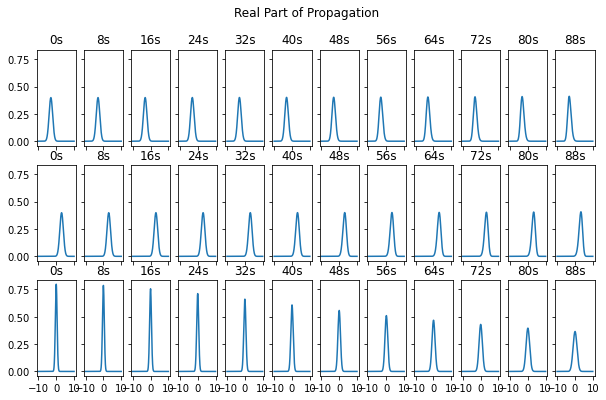

In [18]:
# transfrom matrix of "a" vectors to real space
chebpsimatvec = []
for thischebamat in chebamatvec:
    chebpsimatvec.append(thischebamat @ fourtox)

chebpsimatvec = np.array(chebpsimatvec)

fig, axs = plt.subplots(nrows=len(a0vec), ncols=numsnapshots, sharex='all', sharey='all', figsize=(10, 6))

for i in range(len(a0vec)):
    for j in range(numsnapshots):
        axs[i, j].plot(xvec, np.abs(chebpsimatvec[i, plottstep * j]) ** 2)
        axs[i, j].set_title(f'{plottstep * j * dt}s')

    print(f'L2 Error of chebpsimatvec for Trajectory {i}:', nl.norm(chebpsimatvec[i] - psimatvec[i]))
    print(f'L-infinite Error of chebpsimatvec for Trajectory {i}:', np.max(np.abs(chebpsimatvec[i] - psimatvec[i])))
    print('')

fig.suptitle('Real Part of Propagation')

plt.show()

Shape chebnormpsimatvec: (3, 101)
Average Norm of Trajectory 0 (should be close to 1):
0.9999999999995853
Average Norm of Trajectory 1 (should be close to 1):
0.9999999999995832
Average Norm of Trajectory 2 (should be close to 1):
0.9999999999999106


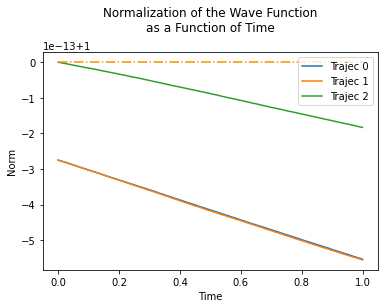

In [19]:
# plot normalization (should be almost flat line at 1)

chebnormpsimatvec = si.trapezoid(np.abs(chebpsimatvec)**2, xvec, axis=2)
print('Shape chebnormpsimatvec:', chebnormpsimatvec.shape)

for i in range(chebnormpsimatvec.shape[0]):
    print(f'Average Norm of Trajectory {i} (should be close to 1):', chebnormpsimatvec[i].sum() / (numts + 1), sep='\n')
    plt.plot(np.arange(numts + 1) * dt, chebnormpsimatvec[i], label=f'Trajec {i}')

plt.hlines(1, 0, numts * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.legend()
plt.show()

---
<h1>Inverse Problem</h1>

In [20]:
# code for constructing a toeplitz matrix from the
# Fourier representation
# flat_toep_vec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])

numtoepelms = 2 * numfour + 1
aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
toepindxmat = jnp.array(aa + bb)
print(toepindxmat.shape)

(65, 65)


In [21]:
# convert numpy objects into JAX objects

jaxamattruevec = jnp.stack(amattruevec)
print('Shape jaxamattruevec:', jaxamattruevec.shape)

jaxchebtofour = jnp.array(chebtofour)
print('Shape jaxchebtofour:', jaxchebtofour.shape)

Shape jaxamattruevec: (3, 101, 65)
Shape jaxchebtofour: (65, 65, 12)


In [22]:
def cobjfn(cff):
    # construct the vmat from Chebyshev coefficients
    vhatmat = jaxchebtofour @ cff
    # vhatmat = jnp.flip(jaxchebtofour @ cff)

    # Hamiltonian matrix
    hhatmat = kmat + vhatmat

    # check if the Hamiltonian matrix is Hermitian
    # print('Check if hhatmat is Hermitian (should be close to 0):', nl.norm(hhatmat - np.transpose(np.conj(hhatmat))), sep='\n')

    # eigendecomposition chebhmat
    spchat, sttshat = jnl.eigh(hhatmat)

    # check if the decomposition diagonalizes chebhmat
    # if this is close to zero then
    # hmat = states @ np.diag(spec) @ np.conj(states).T
    # print('Check if hhatmat is diagonalized (should be close to 0):', nl.norm(hhatmat @ sttshat - sttshat @ np.diag(spchat)), sep='\n')

    # check if the eigenstates are unitary
    # print('Check if sttshat is Unitary (should be close to 0):', nl.norm(sttshat @ np.transpose(np.conj(sttshat)) - np.eye(2 * numfour + 1)), sep='\n')
    # print('')

    # check if hhatmat equal to hmattrue when given cfftrue
    # print('L2 error of hhatmat and hmattrue (should be close to 0):', nl.norm(hhatmat - hmattrue), sep='\n')
    # print('L-infinite error of hhatmat and hmattrue (should be close to 0):', np.max(np.abs(hhatmat - hmattrue)), sep='\n')

    # check if spchat equal to spctrue when given cfftrue
    # print('L2 error of spchat and spctrue (should be close to 0):', nl.norm(spchat - spctrue), sep='\n')
    # print('L-infinite error of spchat and spctrue (should be close to 0):', np.max(np.abs(spchat - spctrue)), sep='\n')

    # check if sttshat equal to stttrue when given cfftrue
    # print('L2 error of sttshat and stttrue (should be close to 0):', nl.norm(sttshat - stttrue), sep='\n')
    # print('L-infinite error of sttshat and stttrue (should be close to 0):', np.max(np.abs(sttshat - stttrue)), sep='\n')

    # propagator matrix
    propahatmat = sttshat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ jnp.transpose(jnp.conj(sttshat))

    ahatmatvec = []
    # propagate the system starting from the initial "a" state
    for thisa0 in a0vec:
        tempahatmat = [thisa0.copy()]
        for i in range(numts):
            tempahatmat.append(propahatmat @ tempahatmat[i])
        # make python list a jax object
        ahatmatvec.append(jnp.stack(tempahatmat))
    # make python list a jax object
    ahatmatvec = jnp.stack(ahatmatvec)

    # compute the sum of objective functions in one line
    residue = ahatmatvec - jaxamattruevec
    objective = jnp.sum(0.5 * jnp.real(jnp.sum(jnp.conj(residue) * residue, axis=1)))

    return objective

In [23]:
# check if the objective function gives zero when the
# chebyshev coefficients of the true potential are fed in
# this should produce a result which is very close to zero
print('Objective for True Chebyshev Coefficients (should be close to 0):', cobjfn(cfftrue), sep='\n')

Objective for True Chebyshev Coefficients (should be close to 0):
3.992011652435903e-24


In [24]:
jitcobjfn = jax.jit(cobjfn)

In [25]:
jitcobjfn(cfftrue)

DeviceArray(3.99201165e-24, dtype=float64)

In [26]:
jaxgradcobjfn = jax.jit(jax.grad(cobjfn))

In [27]:
# check if the JAX grad of the objective function works
# this should give all zeros (or close to that)
print('jaxgradcobjfn(cvec) (should be close to 0):', jaxgradcobjfn(cfftrue), sep='\n')

jaxgradcobjfn(cvec) (should be close to 0):
[ 6.80841835e-13  1.17715169e-13 -3.45044428e-13 -2.96345828e-13
 -4.49162285e-13  3.30242544e-13  1.20968986e-12 -1.96614551e-13
 -1.50982580e-12 -6.11115467e-14  1.27506872e-12  3.70480297e-13]


---
**Initialize with true coefficients perturbed by uniform random noise**

In [28]:
# easy test case: initialize theta with true theta perturbed with
# random normally distributed noise with a small variance.
# This should be easy for the optimizer to converge to a good minimum

seed = 1234  # set to None for random initialization
cfftrub = cfftrue.copy()
cfftrub += 0.25 * np.random.default_rng(seed).normal(size=cfftrue.shape)
# cfftrub += 5.0 * np.random.default_rng(seed).normal(size=cvec.shape)

In [29]:
restrubjaxgrad = so.minimize(jitcobjfn, cfftrub, jac=jaxgradcobjfn, tol=1e-12, options={'maxiter': 200, 'disp': True, 'gtol': 1e-15}).x

         Current function value: 0.000000
         Iterations: 111
         Function evaluations: 269
         Gradient evaluations: 246


In [30]:
def sqrerrorfn(x, cffs):
    return (ss.eval_chebyt(chebnvec, x / L) @ cffs - v(x)) ** 2

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(cfftrue)))[0], sep='\n')

Continuous L2 Error of Potential using Quadrature Method:
4.478500922978152e-14


Objective of the Learned Coefficients:
2.5955313514144117e-24
Vec L2 Norm of Gradient of the Learned Coefficients:
1.676752294527669e-12
Continuous L2 Error of Potential using Quadrature Method:
3.830205799096414e-10


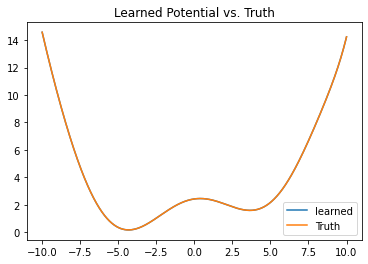

In [31]:
print('Objective of the Learned Coefficients:', cobjfn(restrubjaxgrad), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(restrubjaxgrad)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(restrubjaxgrad)))[0], sep='\n')

# plot learned vs true
# plt.plot(xvec, chebtox @ cfftrub, label='initial')
plt.plot(xvec, chebtox @ restrubjaxgrad, label='learned')
plt.plot(xvec, vxvec, label='Truth')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---
**Uniform Random Initialization**

In [32]:
seed = 1234  # set to None for random initialization
cffform = np.random.default_rng(seed).uniform(low=-5.0, high=5.0, size=cfftrue.shape)

In [33]:
resform = so.minimize(jitcobjfn, cffform, jac=jaxgradcobjfn, tol=1e-15, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-14}).x

         Current function value: 0.000000
         Iterations: 134
         Function evaluations: 313
         Gradient evaluations: 297


Objective of the Learned Coefficients:
3.225981834017433e-24
Vec L2 Norm of Gradient of the Learned Coefficients:
1.3591848931107718e-12
Continuous L2 Error of Potential using Quadrature Method:
8.808442253066008e-11


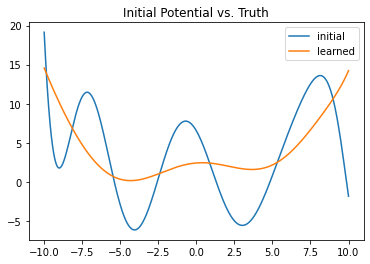

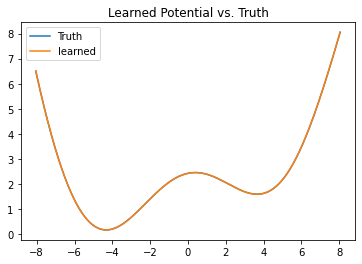

In [34]:
print('Objective of the Learned Coefficients:', cobjfn(resform), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(resform)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(resform)))[0], sep='\n')

# plot initial vs learned
plt.plot(xvec, chebtox @ cffform, label='initial')
plt.plot(xvec, chebtox @ resform, label='learned')
plt.title('Initial Potential vs. Truth')
plt.legend()
plt.show()

# plot true vs learned
plt.plot(xvec[100:-100], vxvec[100:-100], label='Truth')
plt.plot(xvec[100:-100], (chebtox @ resform)[100:-100], label='learned')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---
<h3>Adjoint Method</h3>

In [35]:
def adjhelper(cff):
    # construct the vmat from Chebyshev coefficients
    vhatmat = jaxchebtofour @ cff
    # vhatmat = jnp.flip(jaxchebtofour @ cff)

    # Hamiltonian matrix
    hhatmat = kmat + vhatmat

    # eigendecomposition chebhmat
    spchat, sttshat = jnl.eigh(hhatmat)

    # propagator matrix of a-vector
    propahatmat = sttshat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ jnp.transpose(jnp.conj(sttshat))

    # propagator of adjoint state (lambda matrix)
    proplmat = sttshat @ jnp.diag(jnp.exp(1j * spchat * dt)) @ jnp.transpose(jnp.conj(sttshat))

    ahatmatvec = []
    lmatvec = []
    # propagate the system starting from the initial "a" state
    for i in range(jaxamattruevec.shape[0]):
        tempahatmat = [a0vec[i].copy()]
        for j in range(numts):
            tempahatmat.append(propahatmat @ tempahatmat[j])
        # make python list a jax object
        ahatmatvec.append(jnp.stack(tempahatmat))

        # propagate the "lambda" vector of coefficients backward
        # in time, i.e., solve the adjoint problem
        templmat = [ahatmatvec[-1][numts] - jaxamattruevec[i][numts]]
        for j in range(numts - 1, 0 - 1, -1):
            templmat.append(ahatmatvec[-1][j] - jaxamattruevec[i][j] + proplmat @ templmat[numts - 1 - j])
        # make python list a jax object
        lmatvec.append(jnp.flipud(jnp.stack(templmat)))

    # make python list a jax object
    ahatmatvec = jnp.stack(ahatmatvec)
    lmatvec = jnp.stack(lmatvec)

    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    derivamats = jnp.einsum('ij,jkm,kl->ilm', jnp.transpose(jnp.conj(sttshat)), jaxchebtofour, sttshat) * jnp.expand_dims(mask, 2)
    # print('sttshat.conj().T.shape', sttshat.conj().T.shape)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil', sttshat, derivamats, jnp.transpose(jnp.conj(sttshat)))

    # ws = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:, 1:]])
    # ws = ws[1:, :]
    # ws = ws.T
    # ctrmats = ws[toepindxmat]
    # derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, ctrmats, sttshat) * jnp.expand_dims(mask, 2)
    # derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, ctrmats, sttshat) * jnp.expand_dims(mask, 2)
    derivamats = jnp.einsum('ij,jkm,kl->ilm', jnp.transpose(jnp.conj(sttshat)), jaxchebtofour, sttshat) * jnp.expand_dims(mask, 2)
    alldmatimag = -1j * dt * jnp.einsum('ij,jkm,kl->mil', sttshat, derivamats, jnp.transpose(jnp.conj(sttshat)))

    alldmat = jnp.vstack([alldmatreal, alldmatimag])
    # alldmat = (jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, chebtofour, sttshat) * jnp.expand_dims(mask, 2)).T
    # print('Shape alldmat', alldmat.shape)

    return ahatmatvec, lmatvec, alldmat

def cgradfn(cffs):
    ahatmatvec, lmatvec, alldmat = adjhelper(cffs)
    # compute all entries of the gradient at once
    gradients = jnp.einsum('bij,ajk,bik->a', jnp.conj(lmatvec[:, 1:, :]), alldmat, ahatmatvec[:, :-1, :]).real
    # print(gradients)
    return gradients[:numcheb + 1]

In [36]:
print('Shape cgradfn(cvec):', cgradfn(cfftrue).shape)

print('Gradients for True Chebyshev Coefficients (should be close to 0):', cgradfn(cfftrue), sep='\n')

print('Norm difference of JAX grads and adjoint grads (should be close to 0):', nl.norm(jaxgradcobjfn(cfftrue) - cgradfn(cfftrue)), sep='\n')

Shape cgradfn(cvec): (12,)
Gradients for True Chebyshev Coefficients (should be close to 0):
[ 6.80841835e-13  1.17715169e-13 -3.45044428e-13 -2.96345828e-13
 -4.49162285e-13  3.30242544e-13  1.20968986e-12 -1.96614551e-13
 -1.50982580e-12 -6.11115467e-14  1.27506872e-12  3.70480297e-13]
Norm difference of JAX grads and adjoint grads (should be close to 0):
7.914929996588512e-25


In [37]:
jitcgradfn = jax.jit(cgradfn)

In [38]:
print('jitcgradfn(cvec):', jitcgradfn(cfftrue), sep='\n')
print('jaxgradcobjfn(cvec):', jaxgradcobjfn(cfftrue), sep='\n')

jitcgradfn(cvec):
[ 7.83239589e-13  1.23343946e-13 -4.23939534e-13 -3.12647145e-13
 -4.31888573e-13  3.54310842e-13  1.26731155e-12 -2.23624444e-13
 -1.62411904e-12 -3.23881742e-14  1.40688242e-12  3.33098784e-13]
jaxgradcobjfn(cvec):
[ 6.80841835e-13  1.17715169e-13 -3.45044428e-13 -2.96345828e-13
 -4.49162285e-13  3.30242544e-13  1.20968986e-12 -1.96614551e-13
 -1.50982580e-12 -6.11115467e-14  1.27506872e-12  3.70480297e-13]


In [39]:
# check if the JAX grads and adjoint grads are close

print('L2 Error of Grads (should be close to 0):', jnl.norm(jaxgradcobjfn(cfftrue) - jitcgradfn(cfftrue)), sep='\n')
print('L-infinity Error of Grads (should be close to 0):', jnp.max(jnp.abs(jaxgradcobjfn(cfftrue) - jitcgradfn(cfftrue))), sep='\n')

L2 Error of Grads (should be close to 0):
2.3365534527754574e-13
L-infinity Error of Grads (should be close to 0):
1.3181370912527147e-13


---
**Initialize with true coefficients perturbed by uniform random noise**

In [40]:
restrubadjgrad = so.minimize(jitcobjfn, cfftrub, jac=jitcgradfn, tol=1e-12, options={'maxiter': 400, 'disp': True, 'gtol': 1e-15}).x

         Current function value: 0.000000
         Iterations: 109
         Function evaluations: 222
         Gradient evaluations: 207


Objective of the Learned Coefficients:
2.691995002596064e-24
Vec L2 Norm of Gradient of the Learned Coefficients:
1.881245403619148e-12
Continuous L2 Error of Potential using Quadrature Method:
7.953948328998829e-10


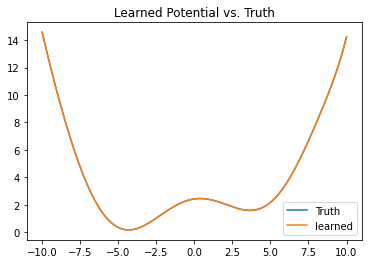

In [41]:
print('Objective of the Learned Coefficients:', cobjfn(restrubadjgrad), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(restrubadjgrad)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(restrubadjgrad)))[0], sep='\n')

# plot learned vs true
plt.plot(xvec, vxvec, label='Truth')
plt.plot(xvec, chebtox @ restrubadjgrad, label='learned')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---
**Uniform Random Initialization**

In [42]:
resformadj = so.minimize(jitcobjfn, cffform, jac=jitcgradfn, tol=1e-15, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-14}).x

         Current function value: 0.000000
         Iterations: 134
         Function evaluations: 288
         Gradient evaluations: 267


Objective of the Learned Coefficients:
2.780256943272286e-24
Vec L2 Norm of Gradient of the Learned Coefficients:
2.4292556200160587e-12
Continuous L2 Error of Potential using Quadrature Method:
6.20960600738981e-11


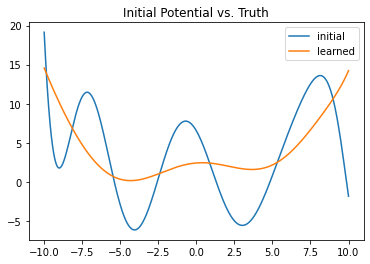

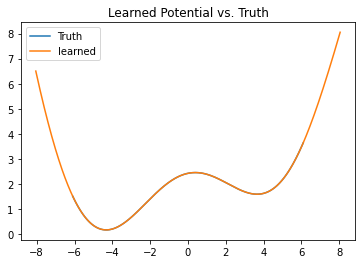

In [43]:
print('Objective of the Learned Coefficients:', cobjfn(resformadj), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(resformadj)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(resformadj)))[0], sep='\n')

# plot initial vs learned
plt.plot(xvec, chebtox @ cffform, label='initial')
plt.plot(xvec, chebtox @ resformadj, label='learned')
plt.title('Initial Potential vs. Truth')
plt.legend()
plt.show()

# plot true vs learned
cut = 200
plt.plot(xvec[cut:-cut], vxvec[cut:-cut], label='Truth')
plt.plot(xvec[100:-100], (chebtox @ resformadj)[100:-100], label='learned')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---
<h3>Test Set Error</h3>

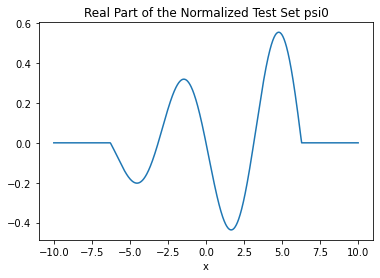

In [46]:
def testsetpsi0(z):
    mask = np.logical_and(z >= -2 * np.pi, z < 2 * np.pi)
    return ((-1 / 20) * z - 0.5) * np.sin(z * mask)

testseta0, testsetnormpsi = mka0(testsetpsi0)

plt.plot(xvec, np.real(testsetnormpsi))
plt.title('Real Part of the Normalized Test Set psi0')
plt.xlabel('x')
plt.show()

---
**Propagating with Learned Potential**

In [66]:
# functions for generating propagator matrix from cheb coefficients

def mk_prop_mat(vmat, verbose = False):

    # Hamiltonian matrix
    hmat = kmat + vmat

    # eigendecomposition chebhmat
    spc, stt = nl.eigh(hmat)

    # propagator matrix
    propa = stt @ np.diag(np.exp(-1j * spc * dt)) @ np.transpose(np.conj(stt))

    if verbose:
        # check if the Hamiltonian matrix is Hermitian
        print('Check if hmat is Hermitian (should be close to 0):', nl.norm(hmat - np.conj(np.transpose(hmat))), sep='\n')

        # check if the decomposition diagonalizes chebhmat
        # if this is close to zero then
        # hmat = states @ np.diag(spec) @ np.conj(states).T
        print('Check if hmat is diagonalized (should be close to 0):', nl.norm(hmat @ stt - stt @ np.diag(spc)), sep='\n')

        # check if the eigenstates are unitary
        print('Check if stt is Unitary (should be close to 0):', nl.norm(stt @ np.conj(np.transpose(stt)) - np.eye(2 * numfour + 1)), sep='\n')
        print('')

        # check if chebhmat equal to hmattrue
        print('L2 error of hmat and hmattrue (should be close to 0):', nl.norm(hmat - hmattrue), sep='\n')
        print('L-infinite error of hmat and hmattrue (should be close to 0):', np.max(np.abs(hmat - hmattrue)), sep='\n')

        # check if chebspc equal to spctrue
        print('L2 error of spc and spctrue (should be close to 0):', nl.norm(spc - spctrue), sep='\n')
        print('L-infinite error of spc and spctrue (should be close to 0):', np.max(np.abs(spc - spctrue)), sep='\n')

        # check if chebstt equal to
        print('L2 error of stt and stttrue (should be close to 0):', nl.norm(stt - stttrue), sep='\n')
        print('L-infinite error of stt and stttrue (should be close to 0):', np.max(np.abs(stt - stttrue)), sep='\n')

    return propa

Check if hmat is Hermitian (should be close to 0):
3.619435162932359e-16
Check if hmat is diagonalized (should be close to 0):
2.542649704545725e-13
Check if stt is Unitary (should be close to 0):
1.3277434857105321e-14

L2 error of hmat and hmattrue (should be close to 0):
1.060591922979226e-10
L-infinite error of hmat and hmattrue (should be close to 0):
3.758550162663442e-12
L2 error of spc and spctrue (should be close to 0):
3.884050819592405e-11
L-infinite error of spc and spctrue (should be close to 0):
1.4026113603904378e-11
L2 error of stt and stttrue (should be close to 0):
2.85723902270232e-06
L-infinite error of stt and stttrue (should be close to 0):
9.629996940519999e-07

0
L2 error of amattesttrue and amattestlearn (should be close to 0):
2.021180199848517e-15
1
L2 error of amattesttrue and amattestlearn (should be close to 0):
4.014922443823046e-15
2
L2 error of amattesttrue and amattestlearn (should be close to 0):
5.937947077978476e-15
3
L2 error of amattesttrue and am

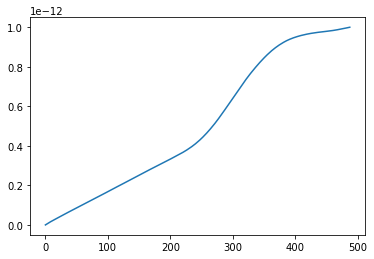

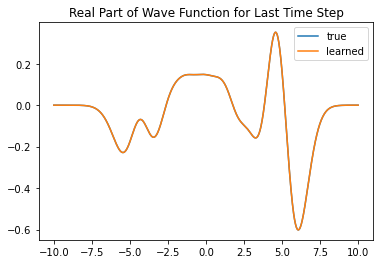

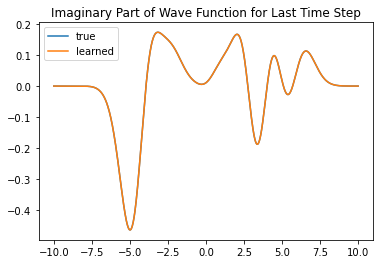

In [59]:
# vmat from learned cheb cffs
vmatlearn = chebtofour @ resformadj

propalearnform = mk_prop_mat(vmatlearn)

print('')

# propagate system starting from initial "a" state
amattesttrue = [thisa0.copy()]
amattestlearn = [thisa0.copy()]
stepL2err = [0]
itr = 0
# for i in range(numts):
while stepL2err[-1] < 1e-12:
    amattesttrue.append(propatrue @ amattesttrue[-1])
    amattestlearn.append(propalearnform @ amattestlearn[-1])
    # check if amattesttrue is equal to amattestlearn
    stepL2err.append(nl.norm(amattesttrue[-1] - amattestlearn[-1]))
    print(itr)
    print('L2 error of amattesttrue and amattestlearn (should be close to 0):', stepL2err[-1], sep='\n')
    # print('L-infinite error of amattesttrue and amattestlearn(should be close to 0):', np.max(np.abs(amattesttrue[-1] - amattestlearn[-1])), sep='\n')
    itr += 1

print('')
print('Propagation Done\n')

plt.plot(stepL2err)
plt.show()

amattesttrue = np.array(amattesttrue)
amattestlearn = np.array(amattestlearn)

plt.plot(xvec, np.real(amattesttrue[-1] @ fourtox), label='true')
plt.plot(xvec, np.real(amattestlearn[-1] @ fourtox), label='learned')
plt.title('Real Part of Wave Function for Last Time Step')
plt.legend()
plt.show()

plt.plot(xvec, np.imag(amattesttrue[-1] @ fourtox), label='true')
plt.plot(xvec, np.imag(amattestlearn[-1] @ fourtox), label='learned')
plt.title('Imaginary Part of Wave Function for Last Time Step')
plt.legend()
plt.show()

# # check if amattesttrue is equal to amattestlearn
# print('L2 error of amattesttrue and amattestlearn (should be close to 0):', nl.norm(amattesttrue - amattestlearn), sep='\n')
# print('L-infinite error of amattesttrue and amattestlearn (should be close to 0):', np.max(np.abs(amattesttrue - amattestlearn)), sep='\n')

---
**Propagating with Learned Potential + Time-Dependent Perturbation**

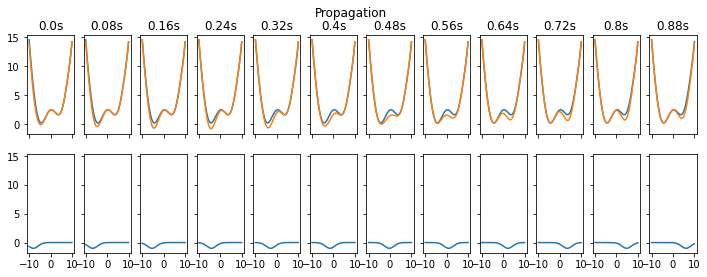

In [63]:
def vt(x, i):
    return -np.exp(-(x + 8 - (16 / numts) * i)**2 / 10)

fig, axs = plt.subplots(nrows=2, ncols=numsnapshots, sharex='all', sharey='all', figsize=(12, 4))

for i in range(numsnapshots):
    vtxvec = vt(xvec, plottstep * i)
    axs[0, i].plot(xvec, vxvec)
    axs[0, i].plot(xvec, vxvec + vtxvec)
    axs[1, i].plot(xvec, vtxvec)
    axs[0, i].set_title(f'{plottstep * i * dt}s')

fig.suptitle('Propagation')

plt.show()

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100


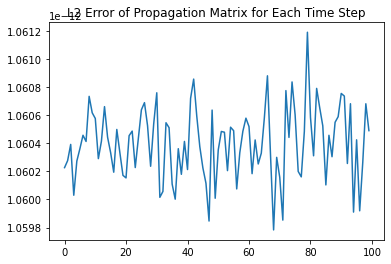

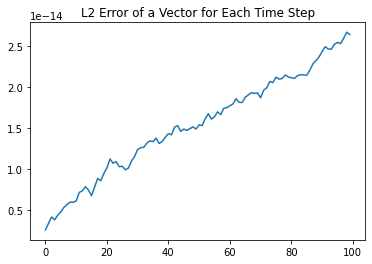

L2 error of amattimetrue and amattimelearn (should be close to 0):
1.663425955417736e-13
L-infinite error of amattimetrue and amattimelearn (should be close to 0):
9.453412150089327e-15


In [71]:
# vmat = vmat1 + vmat2 + ... so we just need to
# compute the time-dependent part of the potential
# for each time step

# propagate system starting from initial "a" state
amattimetrue = [thisa0.copy()]
amattimelearn = [thisa0.copy()]
stepL2errtime = []
stepL2errtimeprop = []
for i in range(numts):
    if not(i % 10):
        print(f'{i} of {numts}')

    fourvtoeptime = []
    for thisfourn in range(2 * numfour + 1):
        def intgrnd(x):
            return vt(x, i) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        fourvtoeptime.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
    vmattime = sl.toeplitz(r=fourvtoeptime, c=np.conj(fourvtoeptime))

    propatruetime = mk_prop_mat(vmattrue + vmattime)
    propalearntime = mk_prop_mat(vmatlearn + vmattime)

    # check if propagation matrices are close
    stepL2errtimeprop.append(nl.norm(propatruetime - propalearntime))

    amattimetrue.append(propatruetime @ amattimetrue[-1])
    amattimelearn.append(propalearntime @ amattimelearn[-1])

    stepL2errtime.append(nl.norm(amattimetrue[-1] - amattimelearn[-1]))


plt.plot(stepL2errtimeprop)
plt.title('L2 Error of Propagation Matrix for Each Time Step')
plt.show()

plt.plot(stepL2errtime)
plt.title('L2 Error of a Vector for Each Time Step')
plt.show()

amattimetrue = np.array(amattimetrue)
amattimelearn = np.array(amattimelearn)

# # check if amattesttrue is equal to amattestlearn
print('L2 error of amattimetrue and amattimelearn (should be close to 0):', nl.norm(amattimetrue - amattimelearn), sep='\n')
print('L-infinite error of amattimetrue and amattimelearn (should be close to 0):', np.max(np.abs(amattimetrue - amattimelearn)), sep='\n')